Setup, importing our modules to be used

In [3]:
import numpy as np
import sep

In [4]:
import astropy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Read image into standard 2-d numpy array

In [5]:
file = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')

print(file)

In [6]:
file_data = file[0].data

print(file_data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Show our first image

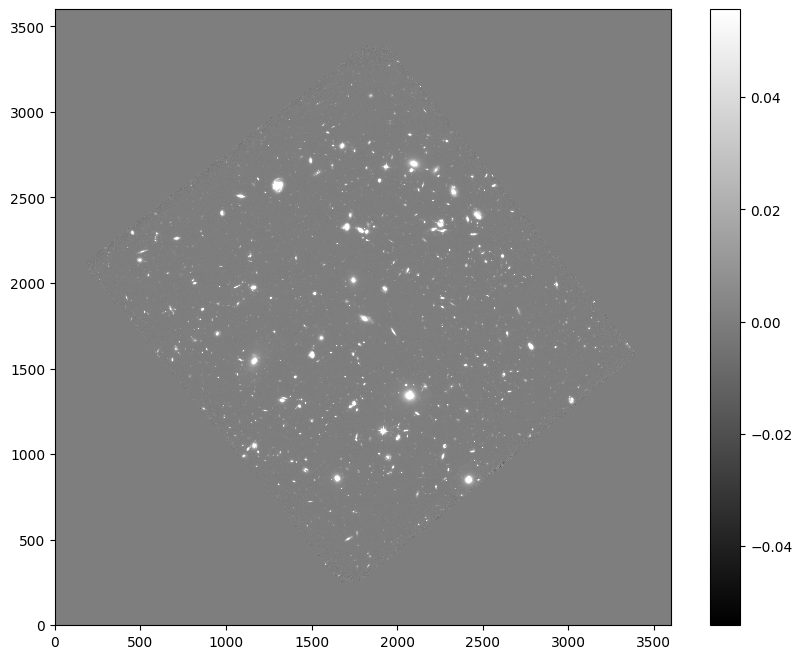

In [7]:
m, s = np.mean(file_data), np.std(file_data)
plt.imshow(file_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("first_diagram.png",bbox_inches="tight",facecolor="white")

Measure a spatially varying background on the image

In [8]:
file_data_new = file_data.byteswap().newbyteorder()
bkg = sep.Background(file_data_new)
#bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

Get a "global" mean and noise of the image background

In [9]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


Evaluate background as 2-d array, same size as original image

In [10]:
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

Show our background/second image

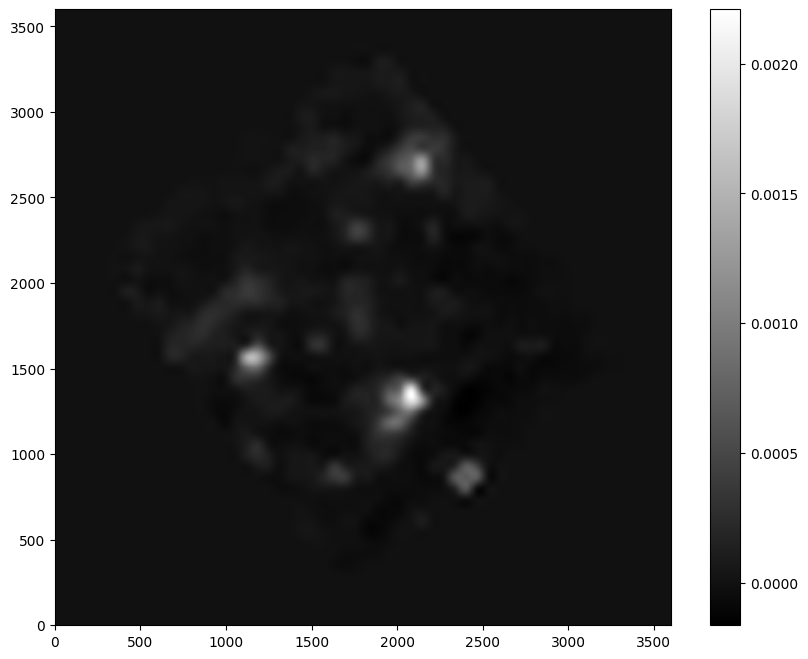

In [11]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("second_diagram.png",bbox_inches="tight",facecolor="white")

Evaluate the background noise as 2-d array, same size as original image

In [12]:
bkg_rms = bkg.rms()

Show the background noise/Third image

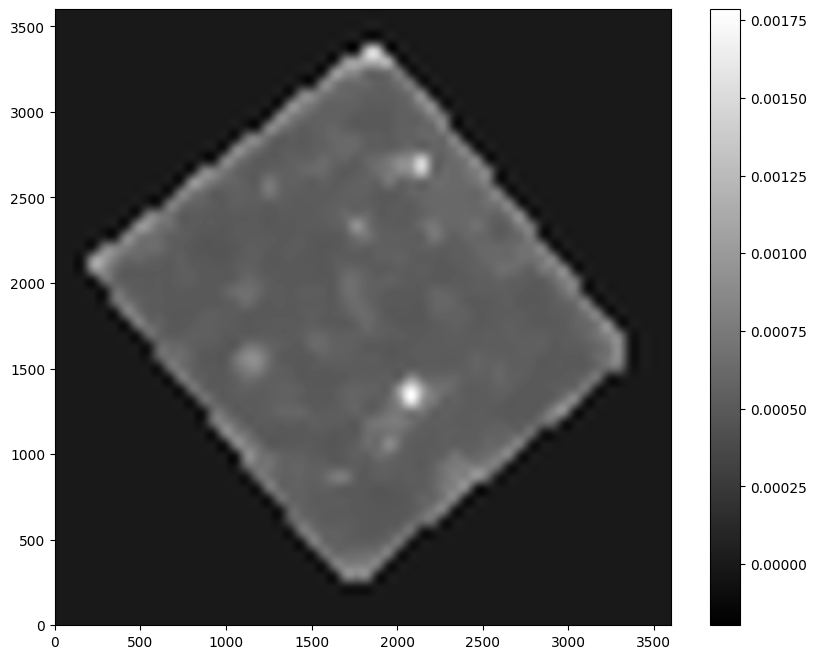

In [13]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("third_diagram.png",bbox_inches="tight",facecolor="white")

Subtract the background

In [14]:
data_sub = file_data - bkg

Creating objects for our object detection

In [15]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

How many objects were created

In [16]:
len(objects)

8643

Creating our fourth image

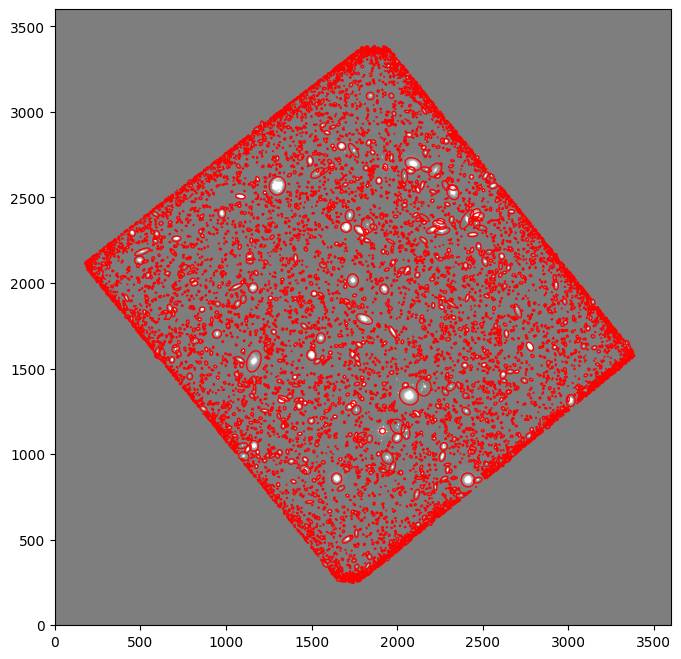

In [17]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("objects_diagram.png",bbox_inches="tight",facecolor="white")

Our available fields

In [18]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Aperture photometry, defining flux, fluxxer, flag

In [19]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

Showing the flux of our first 10 objects

In [20]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


The amount of sources is: 8643


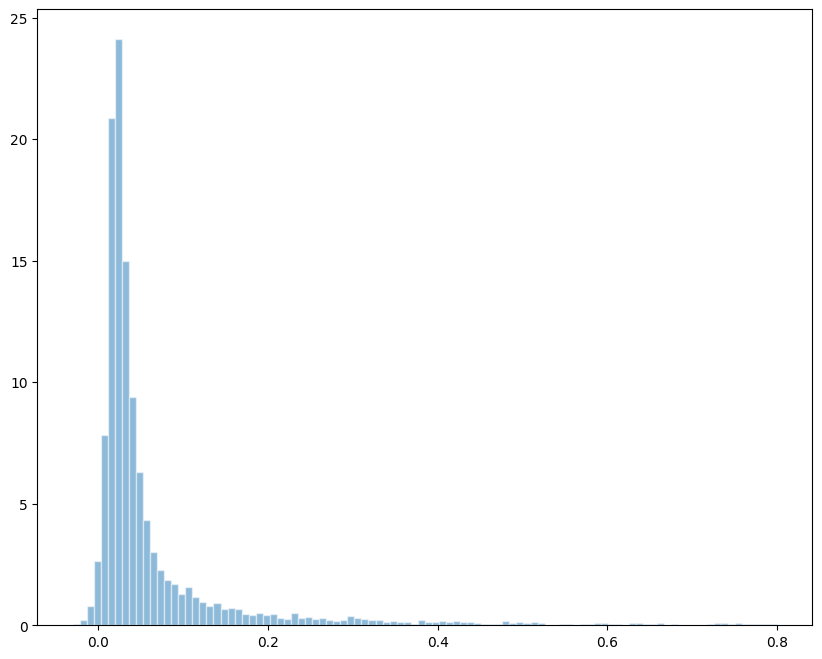

In [21]:
flux_histogram = plt.hist(flux,bins=100,range=(-0.03,0.8),alpha=0.5,edgecolor='white',density=True)
print("The amount of sources is:",len(flux))

In [22]:
flux_mean = np.mean(flux)
flux_standard = np.std(flux)
flux_median = np.median(flux)

print("The mean of the flux is:",flux_mean)
print("The standard deviation of the flux is:",flux_standard)
print("The median of the flux is:",flux_median)

The mean of the flux is: 0.3617466258281149
The standard deviation of the flux is: 9.241925555851745
The median of the flux is: 0.030954822942148894


What is the furthest outlier from the mean? How many standard deviations is it away from the mean? Which element in flux is it?

In [54]:
max_outlier = np.argmax(flux-flux_mean)
print("Our furthest outlier from the mean is:",max_outlier)

Our furthest outlier from the mean is: 2059


In [55]:
std_dist = (flux[max_outlier] - flux_mean)/flux_standard
print("Our furthest outlier is",std_dist,"standard deviations away from the mean.")

Our furthest outlier is 87.31249046216263 standard deviations away from the mean.


Where is the outlier in the image?

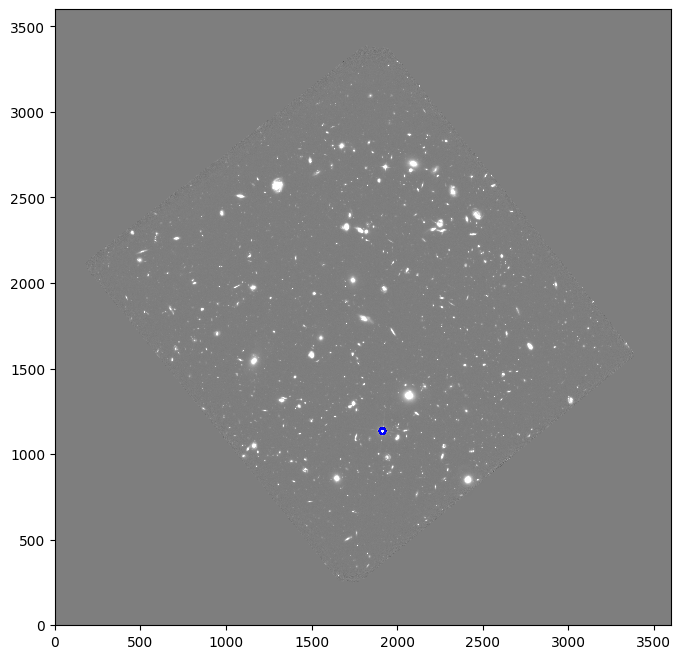

In [56]:
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(objects)):    
    e_max = Ellipse(xy=(objects['x'][2059], objects['y'][2059]),
                width=6*objects['a'][2059],
                height=6*objects['b'][2059],
                angle=objects['theta'][2059] * 180. / np.pi)
    e_max.set_facecolor('none')
    e_max.set_edgecolor('blue')
    ax.add_artist(e_max)

Open up the f125w and f160w files to use for RGB

In [65]:
hdu1 = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
hdu2 = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
hdu3 = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')

data1 = hdu1[0].data
data2 = hdu2[0].data
data3 = hdu3[0].data

Rescale our images

In [66]:
def rescale_image(data):
    pdata_tmp=data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

In [68]:
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin,vmax=vpmax)

Use the rescaled images and create limits for the data

In [72]:
data1res, d1min, d1max = rescale_image(data1)
data2res, d2min, d2max = rescale_image(data2)
data3res, d3min, d3max = rescale_image(data3)

In [73]:
data1res[data1res<d1min] = d1min
data1res[data1res>d1max] = d1max
data2res[data2res<d2min] = d2min
data2res[data2res>d2max] = d2max
data3res[data3res<d3min] = d3min
data3res[data3res>d3max] = d3max

Create my RGB image

In [74]:
rgb = np.zeros((data2res.shape[0], data2res.shape[1], 3))
rgb[:,:,0] = (data1res-d1min)/(d1max-d1min)
rgb[:,:,1] = (data1res-d2min)/(d2max-d2min)
rgb[:,:,2] = (data3res-d3min)/(d3max-d3min)

[W 2024-12-05 19:38:20,799.799 matplotlib.image] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


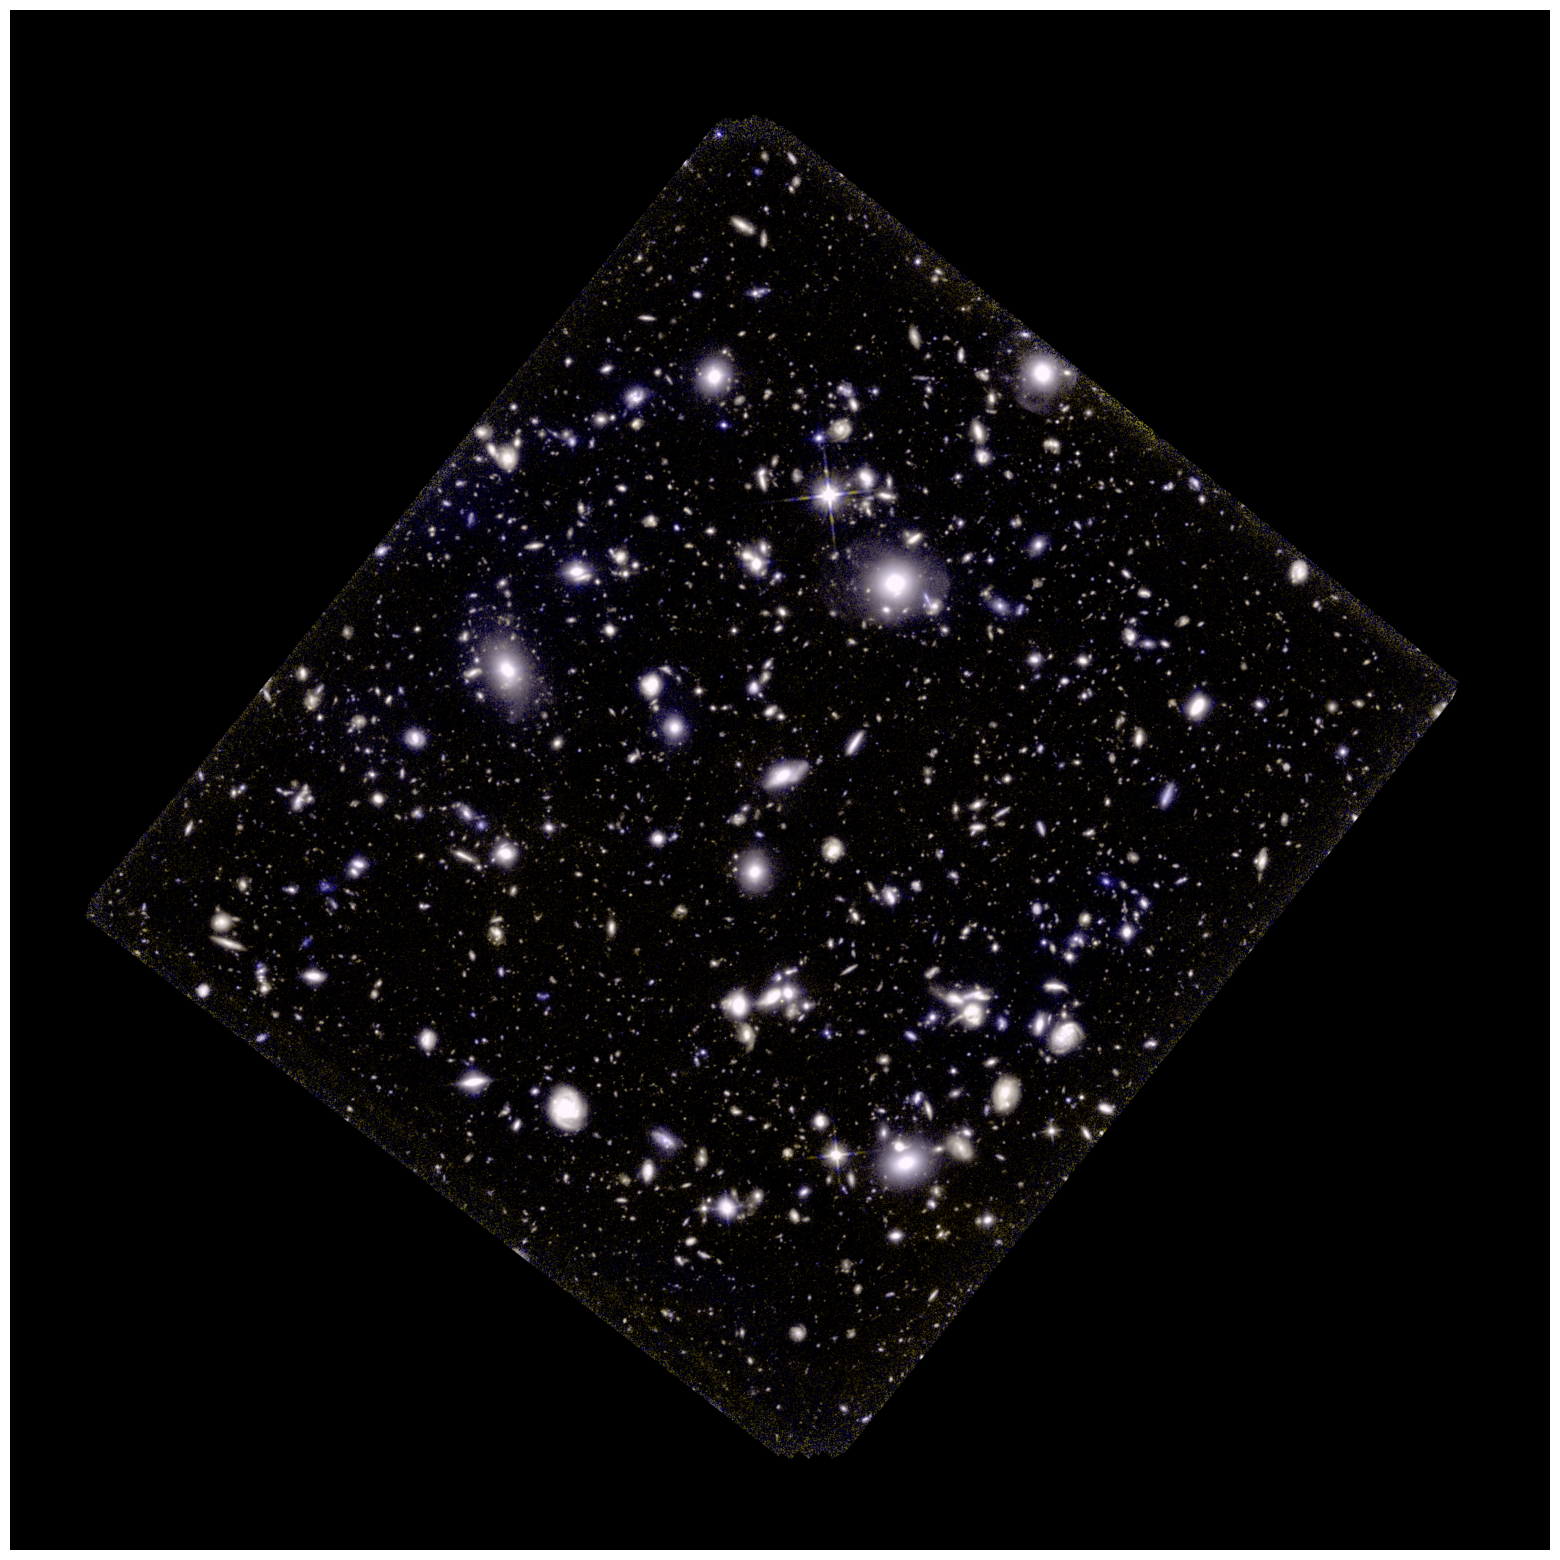

In [75]:
f,ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('rgb_astr_final_image.png',bbox_inches='tight',pad_inches=0,dpi=600)